# Testing Piecewise Polytropic EOS
## Author: Leo Werneck

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#introduction): **Introduction**
1. [Step 2](#plugging_in_values): **Plugging in some values**
1. [Step 3](#p_cold): **Taking a look at $P_{\rm cold}$**
    1. [Step 3.a](#p_cold__computing): *A function to evaluate $P_{\rm cold}$ based on `IllinoisGRMHD`*
    1. [Step 3.b](#p_cold__plotting): *Plotting $P_{\rm cold}\left(\rho\right)$*
1. [Step n](#latex_pdf_output): **Output this module to $\LaTeX$-formatted PDF file**

<a id='introduction'></a>

# Step 1: Introduction \[Back to [top](#toc)\]
$$\label{introduction}$$

We will test here a few piecewise polytrope (PP) equation of state (EOS) relations. The main reference we will be following is [J.C. Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf), but we will also try out [the approach of `Whisky`, presented in Takami *et al.* (2014)](https://arxiv.org/pdf/1412.3240v2.pdf)

First we will start with the original one implemented by IllinoisGRMHD:

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho^{\Gamma_{0}} & , & \rho \leq \rho_{0}\\
K_{1}\rho^{\Gamma_{1}} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
\vdots &  & \vdots\\
K_{j}\rho^{\Gamma_{j}} & , & \rho_{j-1} \leq \rho \leq \rho_{j}\\
\vdots &  & \vdots\\
K_{N-1}\rho^{\Gamma_{N-1}} & , & \rho_{N-2} \leq \rho \leq \rho_{N-1}\\
K_{N}\rho^{\Gamma_{N}} & , & \rho \geq \rho_{N-1}
\end{matrix}
\right.
}\ .
$$

Notice that we have the following sets of variables:

$$
\left\{\underbrace{\rho_{0},\rho_{1},\ldots,\rho_{N-1}}_{N\ {\rm values}}\right\}\ ;\
\left\{\underbrace{K_{0},K_{1},\ldots,K_{N}}_{N+1\ {\rm values}}\right\}\ ;\
\left\{\underbrace{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}}_{N+1\ {\rm values}}\right\}\ .
$$

Also, notice that $K_{0}$ and the entire sets $\left\{\rho_{0},\rho_{1},\ldots,\rho_{N-1}\right\}$ and $\left\{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}\right\}$ must be specified by the user. The values of $\left\{K_{1},\ldots,K_{N}\right\}$, on the other hand, are determined by imposing that $P_{\rm cold}$ be continuous, i.e.

$$
P_{\rm cold}\left(\rho_{0}\right) = K_{0}\rho_{0}^{\Gamma_{0}} = K_{1}\rho_{0}^{\Gamma_{1}} \implies
\boxed{K_{1} = K_{0}\rho_{0}^{\Gamma_{0}-\Gamma_{1}}}\ .
$$

Analogously,

$$
\boxed{K_{j} = K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-\Gamma_{j}}\ ,\ j\in\left[1,N\right]}\ .
$$

<a id='plugging_in_values'></a>

# Step 2: Plugging in some values \[Back to [top](#toc)\]
$$\label{plugging_in_values}$$

Just so that we work with realistic values (i.e. values actually used by researchers), we will implement a simple check using the values from [Table II in J.C. Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf):

| $\rho_{i}$ | $\Gamma_{i}$ | $K_{\rm expected}$ |
|------------|--------------|--------------------|
|2.44034e+07 |   1.58425    |    6.80110e-09     |
|3.78358e+11 |   1.28733    |    1.06186e-06     |
|2.62780e+12 |   0.62223    |    5.32697e+01     |
|     $-$    |   1.35692    |    3.99874e-08     |

In [19]:
# Determining K_{i} i != 0
# We start by setting up all the values of rho_{i}, Gamma_{i}, and K_{0}
import numpy as np
rho_poly   = [2.44034e+07,3.78358e+11,2.62780e+12]
Gamma_poly = [1.58425,1.28733,0.62223,1.35692]
K_poly     = [6.80110e-09,0,0,0]
K_expected = [6.80110e-09,1.06186e-06,5.32697e+01,3.99874e-08]
NEOS = len(rho_poly)+1

for j in range(1,NEOS):
    K_poly[j] = K_poly[j-1] * rho_poly[j-1]**(Gamma_poly[j-1] - Gamma_poly[j])
    print("K_poly["+str(j)+"] = "+str(K_poly[j])+\
          " | K_expected["+str(j)+"] = "+str(K_expected[j])+\
          " | Diff = "+str(np.fabs(K_poly[j] - K_expected[j])))

K_poly[1] = 1.06184448333e-06 | K_expected[1] = 1.06186e-06 | Diff = 1.5516672146434653e-11
K_poly[2] = 53.275084584 | K_expected[2] = 53.2697 | Diff = 0.005384583961500766
K_poly[3] = 3.99920691724e-08 | K_expected[3] = 3.99874e-08 | Diff = 4.669172431909315e-12


<a id='p_cold'></a>

# Step 3: Taking a look at $P_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{p_cold}$$

<a id='p_cold__computing'></a>

## Step 3.a: A function to evaluate $P_{\rm cold}$ based on `IllinoisGRMHD` \[Back to [top](#toc)\]
$$\label{p_cold__computing}$$

The results above look reasonable to the expected ones. Let us then see what the plot of $P_{\rm cold}\times\rho$ looks like. For the case of our specific example, which has $N_{\rm EOS}=4$ (where $N_{\rm EOS}$ stands for the number of polytropic EOSs used), we have

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho^{\Gamma_{0}} & , & \rho \leq \rho_{0}\\
K_{1}\rho^{\Gamma_{1}} & , & \rho_{0} \leq \rho \leq \rho_{1}\\
K_{2}\rho^{\Gamma_{2}} & , & \rho_{1} \leq \rho \leq \rho_{2}\\
K_{3}\rho^{\Gamma_{3}} & , & \rho \geq \rho_{2}
\end{matrix}
\right.
}\ .
$$

In [ ]:
# Set the pressure through the polytropic EOS: P_cold = K * rho^{Gamma}
def Pressure(rho,rho_poly,Gamma_poly,K_poly,NEOS):
    if rho < rho_poly[0] or NEOS==1:
        return K_poly[0] * rho**Gamma_poly[0]
    
    for j in range(1,NEOS-1):
        if rho >= rho_poly[j-1] and rho < rho_poly[j]:
            return K_poly[j] * rho**Gamma_poly[j]
        
    if rho >= rho_poly[NEOS-2]:
        return K_poly[NEOS-1] * rho**Gamma_poly[NEOS-1]

<a id='p_cold__plotting'></a>

## Step 3.b: Plotting $P_{\rm cold}\left(\rho\right)$ \[Back to [top](#toc)\]
$$\label{p_cold__plotting}$$

To create a reasonably interesting plot, which will also test all regions of our piecewise polytrope EOS, let us plot $P_{\rm cold}\left(\rho\right)$ with $\rho\in\left[\frac{\rho_{0}}{10},10\rho_{2}\right]$.

**Remember**: We *don't* expect $P_{\rm cold}$ to be *smooth*, but we *do* expect it to be *continuous* (by construction).

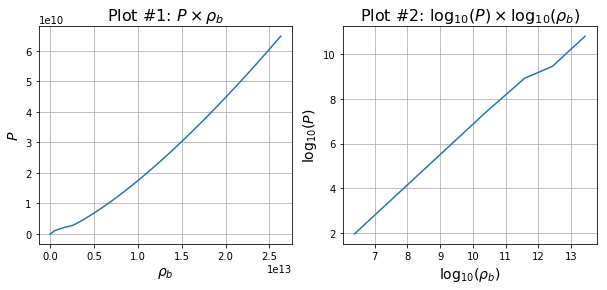

In [73]:
# Set rho in [rho_poly[0]/10,rho_poly[2]*10]
rho_for_plot = np.linspace(rho_poly[0]/10,rho_poly[NEOS-2]*10,1000)

# Set P_{cold}(rho)
P_for_plot   = np.linspace(0,0,1000)
for i in range(len(P_for_plot)):
    P_for_plot[i] = Pressure(rho_for_plot[i],rho_poly,Gamma_poly,K_poly,NEOS)

# Plot P_{cold}(rho) x rho
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,4))
ax1 = f.add_subplot(121)
ax1.set_title(r"Plot #1: $P\times\rho_{b}$",fontsize='16')
ax1.set_xlabel(r"$\rho_{b}$",fontsize='14')
ax1.set_ylabel(r"$P$",fontsize='14')
ax1.grid()
ax1.plot(rho_for_plot,P_for_plot)

ax2 = f.add_subplot(122)
ax2.set_title(r"Plot #2: $\log_{10}\left(P\right)\times\log_{10}\left(\rho_{b}\right)$",fontsize='16')
ax2.set_xlabel(r"$\log_{10}\left(\rho_{b}\right)$",fontsize='14')
ax2.set_ylabel(r"$\log_{10}\left(P\right)$",fontsize='14')
ax2.grid()
ax2.plot(np.log10(rho_for_plot),np.log10(P_for_plot))

<a id='eps_cold'></a>

# Step 4: Taking a look at $\epsilon_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{eps_cold}$$

<a id='latex_pdf_output'></a>

# Step n: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.pdf](Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means).

In [77]:
import os
nrpy_dir_path = os.path.join("..","..")
latex_nrpy_style_path = os.path.join(nrpy_dir_path,"latex_nrpy_style.tplx")
!jupyter nbconvert --to latex --template $latex_nrpy_style_path Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.ipynb
!pdflatex -interaction=batchmode Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.tex
!pdflatex -interaction=batchmode Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.tex
!pdflatex -interaction=batchmode Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-IllinoisGRMHD__piecewise_polytrope_tests.ipynb to latex
/Users/werneck/anaconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/Users/werneck/anaconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
/Users/werneck/anaconda3/lib/python3.7/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (2.2.3.2).
Your version must be at least (1.12.1) but less than (2.0.0).
Refer to http://pandoc.org/installing.html.
Continuin